The point and line-segment plotting provided by Datashader can be put together in different ways to visualize specific types of data. For instance, network graph data, i.e., networks of nodes connected by edges, can very naturally be represented by points and lines.  Here we will show examples of using Datashader's graph-specific plotting tools, focusing on how to visualize very large graphs while allowing any portion of the rendering pipeline to replaced with components suitable for specific problems.

First, we'll import the packages we are using and demonstrating here.


In [2]:
import math
import numpy as np
import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle

from itertools import chain

## Graph (node) layout

Some graph data is inherently spatial, such as connections between geographic locations, and these graphs can simply be plotted by connecting each location with line segments. However, most graphs are more abstract, with nodes having no natural position in space, and so they require a "layout" operation to choose a 2D location for each node before the graph can be visualized.  Unfortunately, choosing such locations is an [open-ended problem involving a complex set of tradeoffs and complications](http://www.hiveplot.com).

Datashader provides a few tools for doing graph layout, while also working with external layout tools. As a first example, let's generate a random graph, with 100 points normally distributed around the origin and 20000 random connections between them:

In [3]:
np.random.seed(0)
n=100
m=20000

nodes = pd.DataFrame(["node"+str(i) for i in range(n)], columns=['name'])
nodes.tail()

,name
95,node95
96,node96
97,node97
98,node98
99,node99


In [4]:
edges = pd.DataFrame(np.random.randint(0,len(nodes), size=(m, 2)),
                     columns=['source', 'target'])
edges.tail()

,source,target
19995,95,22
19996,16,17
19997,10,17
19998,61,69
19999,56,23


Here you can see that the nodes list is a columnar dataframe with an index value and name for every node.  The edges list is a columnar dataframe listing the index of the source and target in the nodes dataframe.  

To make this abstract graph plottable, we'll need to choose an x,y location for each node. There are two simple and fast layout algorithms included:

In [5]:
circular  = circular_layout(nodes, uniform=False)
randomloc = random_layout(nodes)
randomloc.tail()

,name,x,y
95,node95,0.523918,0.285108
96,node96,0.262981,0.748632
97,node97,0.063802,0.487605
98,node98,0.096956,0.980359
99,node99,0.047649,0.940896


Random layout,Circular layout

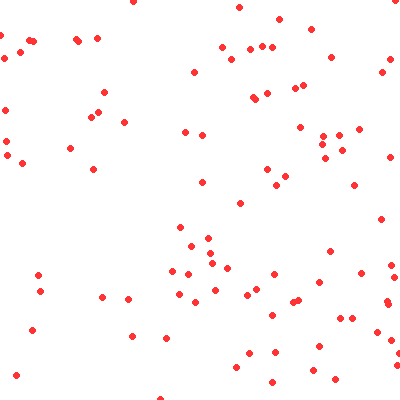
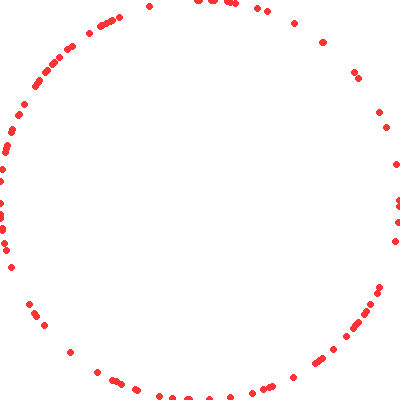

In [5]:
cvsopts = dict(plot_height=400, plot_width=400)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

tf.Images(nodesplot(randomloc,"Random layout"),
          nodesplot(circular, "Circular layout"))

The circular layout provides an option to distribute the nodes randomly along the circle or evenly, and here we've chosen the former.

The two layouts above ignore the connectivity structure of the graph, focusing only on the nodes. The [ForceAtlas2](http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0098679&type=printable) algorithm is a more complex approach that treats connections like physical forces (a force-directed approach) in order to construct a layout for the nodes based on the network connectivity:

CPU times: user 454 ms, sys: 32.5 ms, total: 487 ms
Wall time: 515 ms


ForceAtlas2 layout

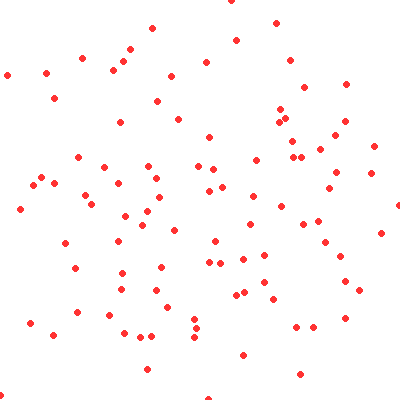

In [6]:
%time forcedirected = forceatlas2_layout(nodes, edges)
tf.Images(nodesplot(forcedirected, "ForceAtlas2 layout"))

This algorithm is designed to place densely connected nodes closer to each other, but of course we will only be able to evaluate how well it has done so once we plot edges (below).

## Edge rendering/bundling

Assuming that we have a suitable layout for the nodes, we can now plot the connections between them.  There are currently two bundling algorithms provided: drawing a line directly between any connected nodes (``connect_edges``), and an iterative "bundling" algorithm ``hammer_bundle`` (a variant of [Hurter, Ersoy, & Telea, ECV-2012](http://www.cs.rug.nl/svcg/Shapes/KDEEB)) that allows edges to curve and then groups nearby ones together to help convey structure. Rendering direct connections should be very quick, even for large graphs, but bundling can be quite computationally intensive.

In [8]:
def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)
    
def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
        
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)

CPU times: user 3.34 s, sys: 77.3 ms, total: 3.42 s
Wall time: 3.59 s
CPU times: user 496 ms, sys: 20.1 ms, total: 516 ms
Wall time: 524 ms
CPU times: user 1min 3s, sys: 858 ms, total: 1min 4s
Wall time: 1min 5s
CPU times: user 55.2 s, sys: 651 ms, total: 55.8 s
Wall time: 58.7 s


Circular layout,Force-directed
"Circular layout, bundled","Force-directed, bundled"

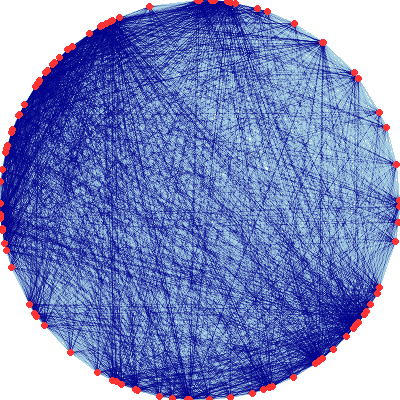
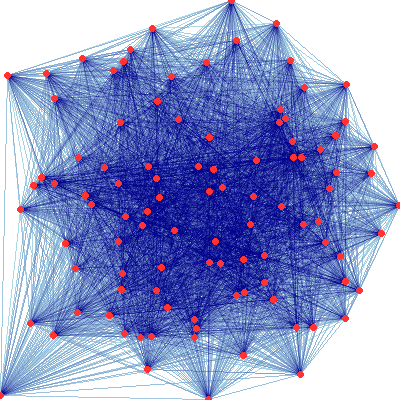
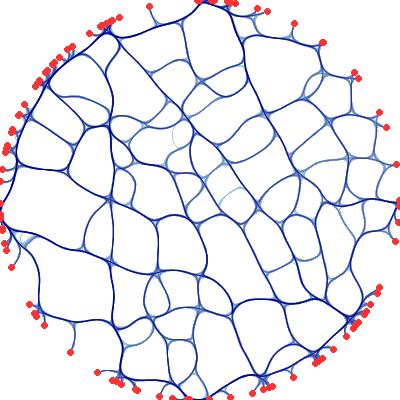
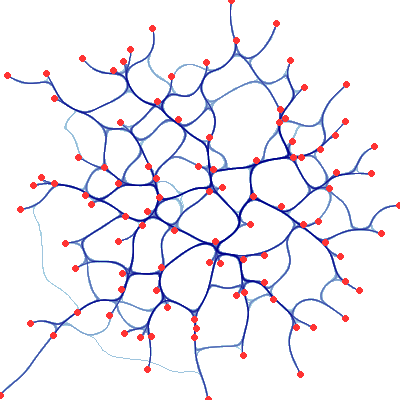

In [9]:
cd = circular
fd = forcedirected

%time cd_d = graphplot(cd, connect_edges(cd,edges), "Circular layout")
%time fd_d = graphplot(fd, connect_edges(fd,edges), "Force-directed") 
%time cd_b = graphplot(cd, hammer_bundle(cd,edges), "Circular layout, bundled")
%time fd_b = graphplot(fd, hammer_bundle(fd,edges), "Force-directed, bundled") 

tf.Images(cd_d,fd_d,cd_b,fd_b).cols(2)

The four examples above plot the same network structure by either connecting the nodes directly with lines or bundling the connections, and by using a random layout or a force-directed layout.  As you can see, these options have a big effect on the resulting visualization. 

Here we'll look more closely at the bundling algorithm, using a simple example where we know the structure: a single node at the center, with random points on a circle around it that connect to the central node (a star graph topology):

<!-- def circle(r,n): return [(math.cos(2*math.pi/n*x)*r,math.sin(2*math.pi/n*x)*r) for x in range(0,n)] -->

In [1]:
n = 75
np.random.seed(0)
x = np.random.random(n)

snodes = pd.DataFrame(np.stack((np.cos(2*math.pi*x),
                               np.sin(2*math.pi*x))).T, columns=['x','y'])
snodes.iloc[0] = (0.0,0.0)
sedges = pd.DataFrame(list(zip((range(1,n)),[0]*n)),columns=['source', 'target'])
star = snodes,sedges

NameError: name 'np' is not defined

In [ ]:
tf.Images(graphplot(snodes, connect_edges(*star),"Star"),
          graphplot(snodes, hammer_bundle(*star),"Star bundled"))

Here you can see the bundling algorithm forms groups of nearby connnections, which helps make the structure at a particular scale clear.  The scale of this structure, i.e., how much bundling is done, is determined by an effective "bandwidth", which is a combination of an `initial_bandwidth` parameter and a `decay` time constant for annealing this bandwidth over time:

In [11]:
%%time
grid =  [graphplot(snodes, 
                   hammer_bundle(*star, iterations=5, decay=decay, initial_bandwidth=bw),
                                 "d={:0.2f}, bw={:0.2f}".format(decay, bw))
    for decay in [0.1, 0.25, 0.5, 0.9] for bw    in [0.1, 0.2, 0.5, 1]]

CPU times: user 7.78 s, sys: 104 ms, total: 7.89 s
Wall time: 7.98 s


"d=0.10, bw=0.10","d=0.10, bw=0.20","d=0.10, bw=0.50","d=0.10, bw=1.00"
"d=0.25, bw=0.10","d=0.25, bw=0.20","d=0.25, bw=0.50","d=0.25, bw=1.00"
"d=0.50, bw=0.10","d=0.50, bw=0.20","d=0.50, bw=0.50","d=0.50, bw=1.00"
"d=0.90, bw=0.10","d=0.90, bw=0.20","d=0.90, bw=0.50","d=0.90, bw=1.00"

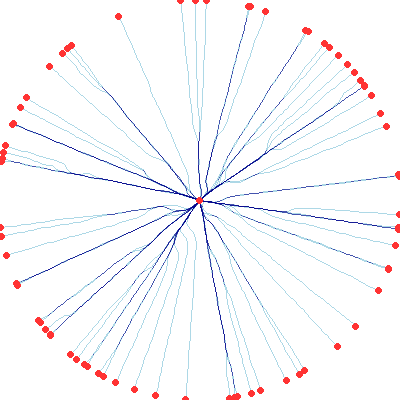
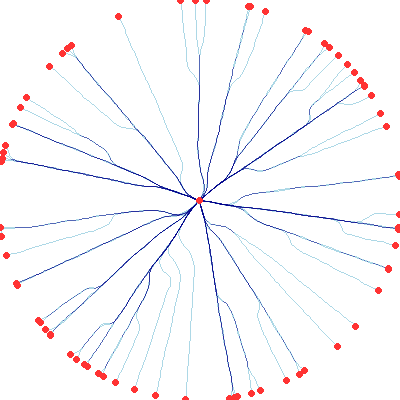
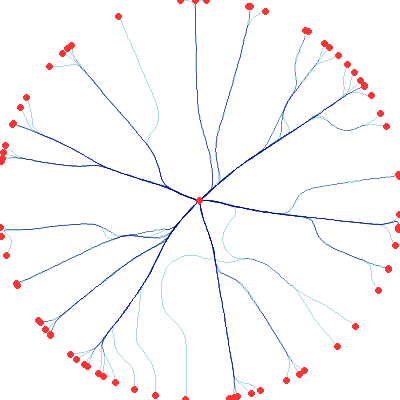
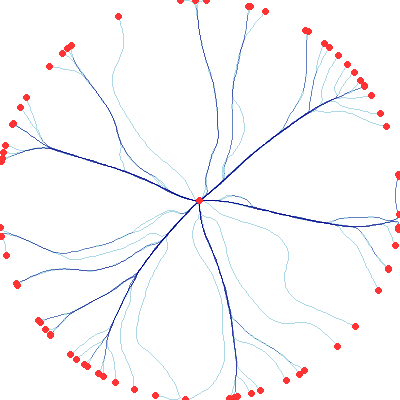
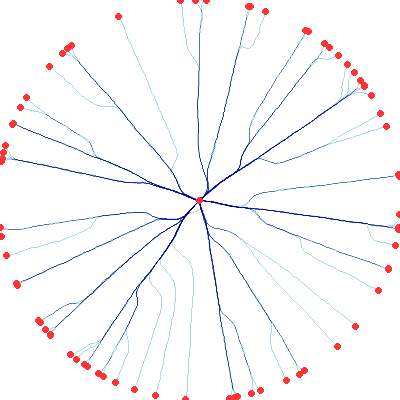
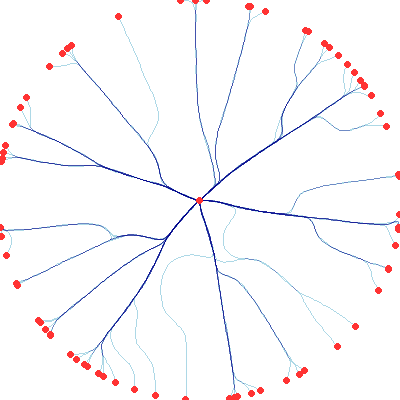
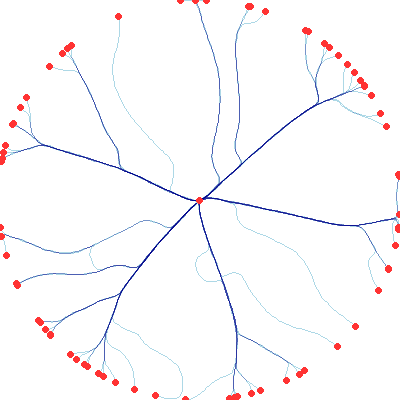
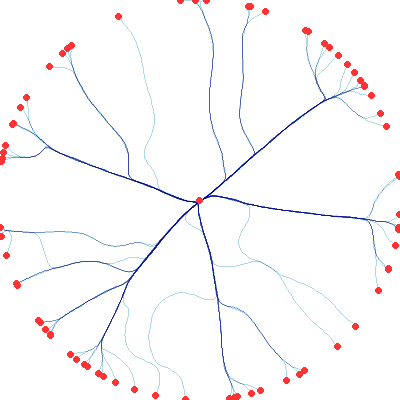
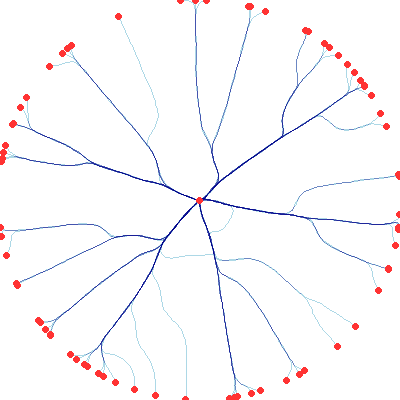
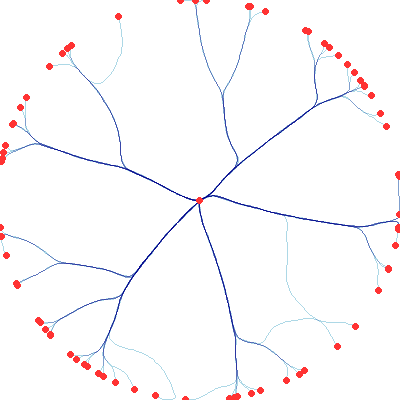
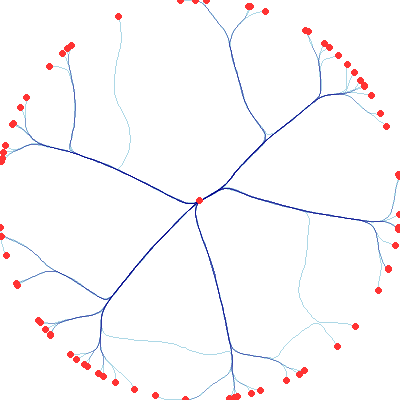
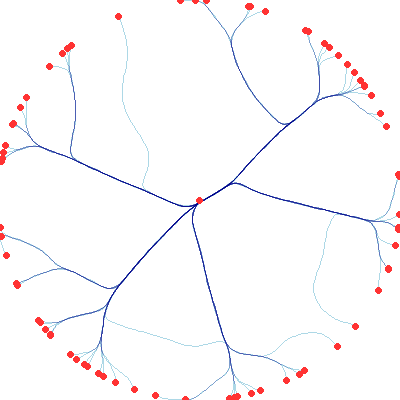
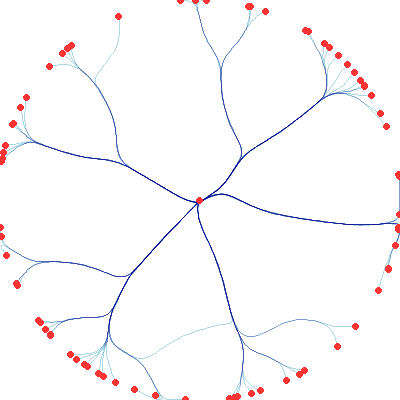
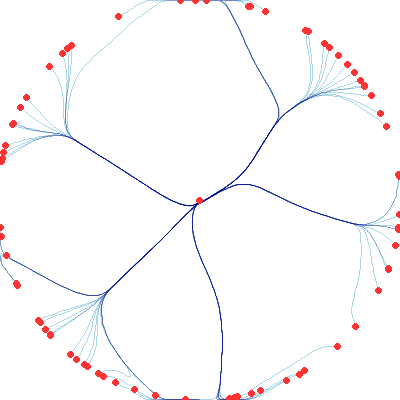
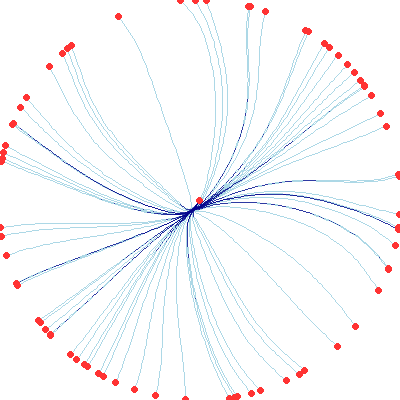
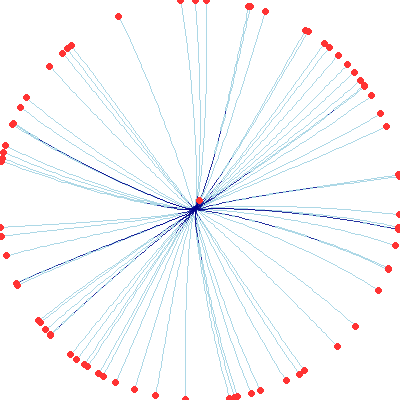

In [12]:
tf.Images(*grid).cols(4)

Starting from the bottom left and moving diagonally to the upper right, the scale of the bundling increases along a diagonal to the upper right, with higher initial bandwidth and higher decay time constants leading to larger-scale bundling.  For the largest decay time constant, the algorithm has failed to converge for large initial bandwidths (the bw 0.5 and 1.0 plots on the bottom row), because the algorithm stops at a specified maximum `iterations`, rather than reaching a fully organized state.

Of course, even when the algorithm does converge, larger amounts of bundling can magnify small amounts of clumping over large scales, which may or may not be relevant to the questions being asked of this data, so it is important to set these parameters appropriately for the types of structures of interest.

<!--
max_iterations=10
hmap = hv.HoloMap({(it, bw, decay): hv.Curve(hammer_bundle(nodes.data, edges.data,
                         decay=decay, initial_bandwidth=bw, iterations=it))
                     for decay in [0.1, 0.25, 0.5, 1, 2] 
                     for bw in [0.1, 0.2, 0.5, 1] 
                     for it in range(max_iterations)},
                   kdims=['Iteration', 'Initial bandwidth', 'Decay'])
    
nodes_ds = datashade(nodes,cmap=["cyan"])
datashade(hmap.grid(['Initial bandwidth', 'Decay']), **sz).map(lambda e_ds: e_ds * nodes, hv.DynamicMap)
-->

# Graphs with categories

One of the main uses for visualizations of large graphs is to examine the connectivity patterns from nodes of different categories. Let's consider an artificial example with four groups of highly interconnected nodes:

In [13]:
np.random.seed(1)
cats,n,m = 4,80,1000

cnodes = pd.concat([
           pd.DataFrame.from_records([("node"+str(i+100*c),"c"+str(c)) for i in range(n)], 
                        columns=['name','cat']) 
             for c in range(cats)], ignore_index=True)
cnodes.cat=cnodes.cat.astype('category')

cedges = pd.concat([
           pd.DataFrame(np.random.randint(n*c,n*(c+1), size=(m, 2)), 
                        columns=['source', 'target'])
         for c in range(cats)], ignore_index=True)

The ``cnodes`` and ``cedges`` data structures form a graph that has clear structure not visible in a random layout, but is easily extracted using the force-directed approach:

CPU times: user 848 ms, sys: 24.9 ms, total: 873 ms
Wall time: 900 ms
CPU times: user 1.09 s, sys: 37.8 ms, total: 1.12 s
Wall time: 1.15 s
CPU times: user 11.7 s, sys: 130 ms, total: 11.8 s
Wall time: 12 s
CPU times: user 5.61 s, sys: 42.7 ms, total: 5.65 s
Wall time: 5.67 s


Random layout,Force-directed
"Random layout, bundled","Force-directed, bundled"

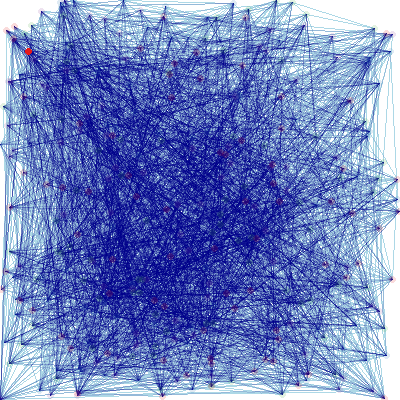
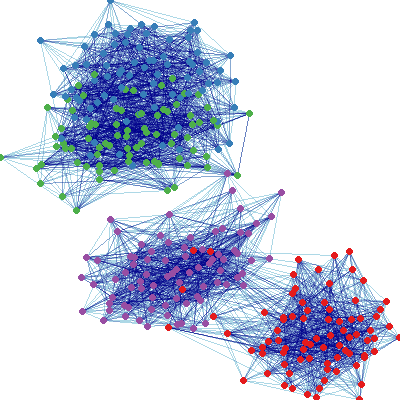
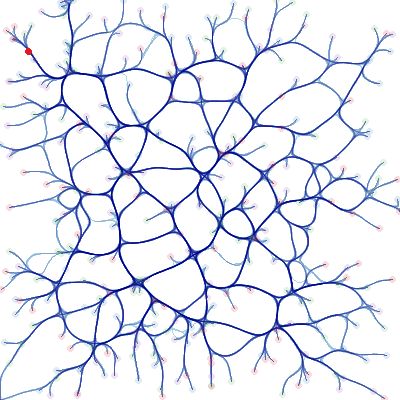
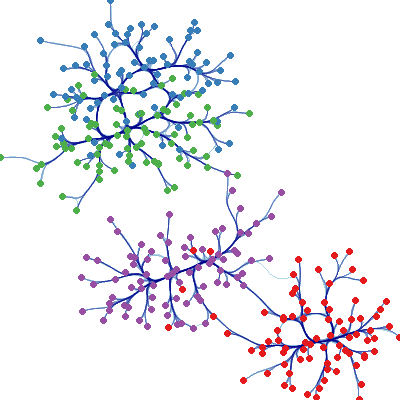

In [14]:
rd = random_layout(     cnodes, cedges)
fd = forceatlas2_layout(cnodes, cedges)

%time rd_d = graphplot(rd, connect_edges(rd,cedges), "Random layout",          cat="cat")
%time fd_d = graphplot(fd, connect_edges(fd,cedges), "Force-directed",         cat="cat") 
%time rd_b = graphplot(rd, hammer_bundle(rd,cedges), "Random layout, bundled", cat="cat")
%time fd_b = graphplot(fd, hammer_bundle(fd,cedges), "Force-directed, bundled",cat="cat") 

tf.Images(rd_d,fd_d,rd_b,fd_b).cols(2)

As you can see, the highly interconnected subgroups are laid out in separate locations in the plane, mostly non-overlapping, allowing these groups to be detected visually in a way that they aren't in a random layout, with or without bundling.

## Using graphs from NetworkX

The above examples constructed networks by hand.  A convenient way to get access to a large number of [graph types](https://networkx.github.io/documentation/stable/reference/generators.html) is the separate [NetworkX](https://networkx.readthedocs.io) package.  Here, we will select several standard graph structures, lay them each out in the same fixed circular shape using NetworkX, and then show how they will appear without bundling, with moderate levels of bundling, and with high amounts of bundling.

In [ ]:
import networkx as nx

def ng(graph,name):
    graph.name = name
    return graph

def nx_layout(graph):
    layout = nx.circular_layout(graph)
    data = [[node]+layout[node].tolist() for node in graph.nodes]

    nodes = pd.DataFrame(data, columns=['id', 'x', 'y'])
    nodes.set_index('id', inplace=True)

    edges = pd.DataFrame(list(graph.edges), columns=['source', 'target'])
    return nodes, edges

def nx_plot(graph, name=""):
    print(graph.name, len(graph.edges))
    nodes, edges = nx_layout(graph)
    
    direct = connect_edges(nodes, edges)
    bundled_bw005 = hammer_bundle(nodes, edges)
    bundled_bw030 = hammer_bundle(nodes, edges, initial_bandwidth=0.30)

    return [graphplot(nodes, direct,         graph.name),
            graphplot(nodes, bundled_bw005, "Bundled bw=0.05"),
            graphplot(nodes, bundled_bw030, "Bundled bw=0.30")]

In [ ]:
n=50
plots = [nx_plot(g) for g in
           [ng(nx.complete_graph(n),        name="Complete"), 
            ng(nx.lollipop_graph(n, 5),     name="Lollipop"),     
            ng(nx.barbell_graph(n,2),       name="Barbell"),
            ng(nx.ladder_graph(n),          name="Ladder"),   
            ng(nx.circular_ladder_graph(n), name="Circular Ladder"), 
            ng(nx.star_graph(n),            name="Star"),
            ng(nx.cycle_graph(n),           name="Cycle")]]

tf.Images(*chain.from_iterable(plots)).cols(3)

As you can see, both bundled and unbundled representations reflect important aspects of the graph structure, but the bundling results do depend on the parameters chosen.  Bundling is also very computationally expensive; nearly all of the time taken to render these plots is for the bundling step.

Note that the `star_graph` example above differs from the one in the previous sections, in that all nodes here connect to a node on the outer circle instead of one in the center, which shows clearly how the layout can affect the resulting visualization.

## Interactive graphs

The above plots all show static images of nodes and edges, with optional category information, but there's no way to see the specific identity of individual nodes.  With small numbers of nodes you can try coloring them to convey identity, but in general the only practical way to reveal identity of nodes or edges is typically interactively, as a user inspects individual items.  Thus interactive plots are often necessary for doing any exploration of real-world graph data.

The simplest way to work with interactive datashaded graphs is to use [HoloViews](http://holoviews.org), which includes specific support for [plotting graphs with and without Datashader](http://holoviews.org/user_guide/Network_Graphs.html):

In [ ]:
import holoviews.operation.datashader as hd
import holoviews as hv
hv.extension("bokeh")

circle = hv.Graph(edges, label='Bokeh edges').opts(node_size=5)
hnodes = circle.nodes.opts(size=5)
dscirc = (hd.dynspread(hd.datashade(circle))*hnodes).relabel("Datashader edges")

circle + dscirc

In these plots, you can select the Bokeh "wheel zoom" from the tool palette and then zoom using your scroll wheel or pan by clicking and dragging.  On a static site like a website or anaconda.org the lines in the Datashader plot will be rescaled blockily as you zoom in, but with a live server it will be dynamically re-rendered to show more detailed structure each time. 

You can try clicking and hovering on either plot to see what interactive features are available; in both cases the behavior for nodes should be the same (as the full set of nodes is being overlaid on both plots), while the edges also support interactivity in the pure-Bokeh version.

As you can see, the pure-Bokeh version provides more interactivity, but the datashaded version will let you see the patterns of connectivity better for large graphs.  The datashader version will also work fine for  arbitrarily large graphs that would overwhelm the browser if used with Bokeh directly.  [HoloViews](http://holoviews.org/user_guide/Network_Graphs.html) makes it simple to switch between these two extremes as needed, using full-interactive plots for small datasets and adding whatever interactivity is required (as in the overlaid node plots on the right above) for larger datasets while rendering the full dataset as the main plot using datashader.

## Real-world examples

The above examples all use artificial datasets, but each real-world dataset will have its own specific properties. We've set up analyses of a few real datasets as well:

### USA airport connections
[![thumb](../assets/images/airport_connections.png)](https://anaconda.org/philippjfr/airport_connections)

### Research institutions linked by joint UK grants

[![thumb](../assets/images/uk_researchers.png)](https://examples.pyviz.org/uk_researchers/uk_researchers.html)

### PCAP computer network data

[![thumb](../assets/images/pcap.png)](https://anaconda.org/philippjfr/packet_capture_graph_hv/notebook)